In [6]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces

class CustomEnv(gym.Env):
    def __init__(self, data, action_spece=3, observation_space=8, balance=10000):
        super(CustomEnv, self).__init__()
        self.data = data.reset_index()
        data['Action'] = 1
        self.actions_data = data.reset_index()

        self.action_space = spaces.Discrete(action_spece)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(observation_space,), dtype=np.float32)

        self._current_step = 0
        self._current_position = 0
        self._total_reward = 0.0

        self._balance = balance
        self._pct_of_balance = 0.1
        self._token_amount = 0
        self._balance_before_sell = 0
        self._last_action = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        self._current_step = 0
        self._total_reward = 0.0
        self._current_position = 0
        self._balance = 10000
        self._token_amount = 0
        self._balance_before_sell = 0
        self._last_action = 0
        
        return (self._next_observation(), self._get_info())

    def _next_observation(self):
        obs = self.data.iloc[self._current_step][['Open', 'High', 'Low', 'Close', 'Volume']].values
        return obs.astype(np.float32)

    def step(self, action):
        current_price = self.data.iloc[self._current_step]['Close']
        reward = 0

        if action == 0:  # Buy
            if self._balance * self._pct_of_balance > 0:
                self._token_amount += self._balance * self._pct_of_balance / current_price
                self._balance -= self._balance * self._pct_of_balance
                reward = 0.01
            elif self._balance < 0:
                reward = -0.5
        elif action == 1:  # Hold
            reward = 0.1
        elif action == 2:  # Sell
            if self._token_amount > 0:
                self._balance_before_sell = self._balance
                self._balance += self._token_amount * current_price
                self._token_amount = 0
                reward = (self._balance - self._balance_before_sell) / 1000
            else:
                reward = -0.5


        self._current_step += 1
        done = self._current_step >= len(self.data) - 1
        obs = self._next_observation()
        self.current_reward = reward
        self._total_reward += reward
        self._last_action = action
        self.actions_data.loc[self._current_step, 'Action'] = action

        return obs, reward, done, False, self._get_info()

    def render(self, mode='human'):
        print(f'Step: {self._current_step}, Last Action: {self._last_action}, Reward: {self.current_reward}, Total Reward: {self._total_reward}, Balance Before: {self._balance_before_sell}, Balance: {self._balance}, Token Amount: {self._token_amount}')

    def close(self):
        return self.actions_data

    def _get_info(self):
        return dict(
            total_reward=self._total_reward,
            balance=self._balance,
            portolio_value = self._balance + self._token_amount * self.data.iloc[self._current_step]['Close']
        )

In [7]:
import yfinance as yf
import ta

def fetch_data_with_indicators(stock_symbol, start, end):
    data = yf.download(stock_symbol, start=start, end=end)

    # # Calculate RSI using 'ta'
    # data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

    # # Calculate MACD using 'ta'
    # macd = ta.trend.MACD(data['Close'], window_slow=26, window_fast=12, window_sign=9)
    # data['MACD'] = macd.macd()
    # data['MACD_Signal'] = macd.macd_signal()
    
    # data = data[['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'MACD_Signal']].dropna()
    return data

In [8]:
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.env_checker import check_env

data = fetch_data_with_indicators('BTC-USD', '2020-01-01', '2023-01-01')

env = CustomEnv(data, action_spece=3, observation_space=5)
check_env(env)

model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

[*********************100%***********************]  1 of 1 completed


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 247      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.954   |
|    explained_variance | 0.0      |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.99     |
|    value_loss         | 0.896    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 279      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.854   |
|    explained_variance | 0.0      |
|    learning_rate      | 0.0007   |
|    n_updates    

[*********************100%***********************]  1 of 1 completed


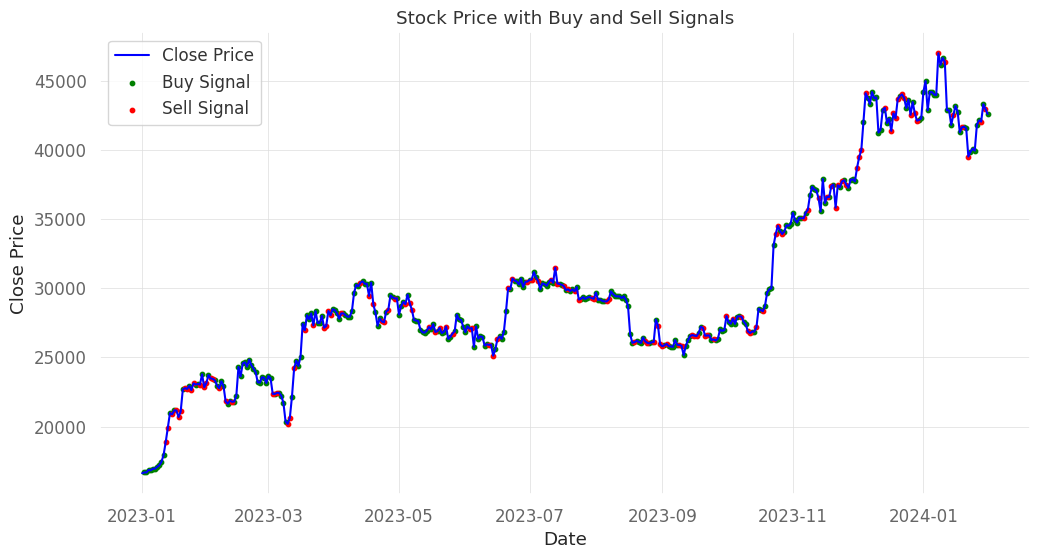

                    Strategy
------------------  ----------
Start Period        2023-01-01
End Period          2024-01-30
Risk-Free Rate      0.0%
Time in Market      69.0%

Cumulative Return   17.03%
CAGR﹪              10.58%

Sharpe              1.08
Prob. Sharpe Ratio  91.02%
Sortino             1.65
Sortino/√2          1.17
Omega               1.35

Max Drawdown        -7.99%
Longest DD Days     82

Gain/Pain Ratio     0.35
Gain/Pain (1M)      1.96

Payoff Ratio        1.28
Profit Factor       1.35
Common Sense Ratio  1.64
CPC Index           0.88
Tail Ratio          1.22
Outlier Win Ratio   8.04
Outlier Loss Ratio  5.5

MTD                 -0.42%
3M                  1.97%
6M                  2.66%
YTD                 -0.42%
1Y                  10.37%
3Y (ann.)           10.58%
5Y (ann.)           10.58%
10Y (ann.)          10.58%
All-time (ann.)     10.58%

Avg. Drawdown       -1.53%
Avg. Drawdown Days  17
Recovery Factor     2.06
Ulcer Index         0.03
Serenity Index      0.62


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


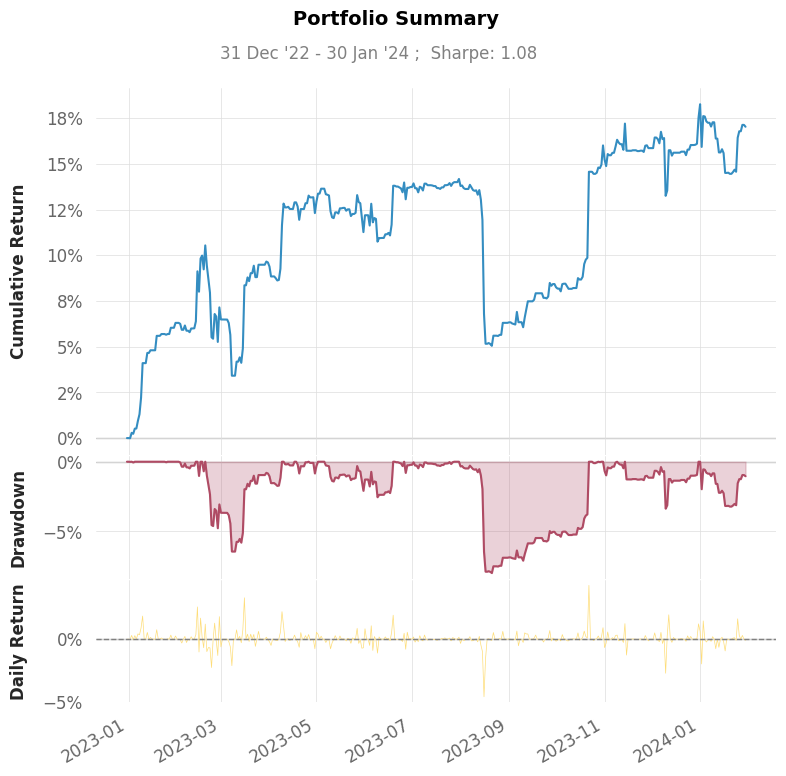

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


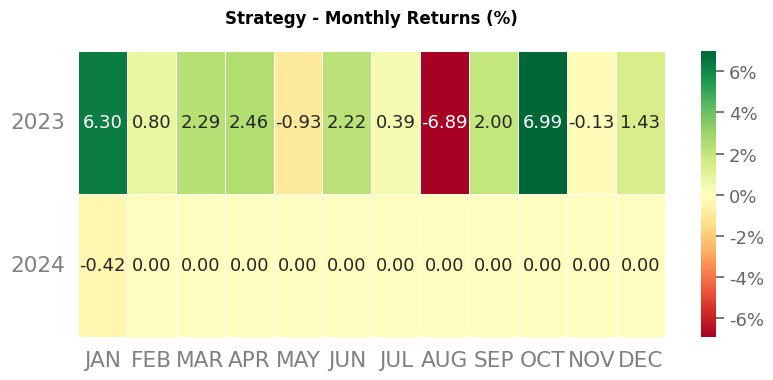

In [9]:
from matplotlib import pyplot as plt
import pandas as pd
from gym_anytrading.envs import Actions
import quantstats as qs

test_data = fetch_data_with_indicators('BTC-USD', '2023-01-01', '2024-02-01')

test_env = CustomEnv(test_data, action_spece=3, observation_space=5)
check_env(test_env)

portfolio_values = []

observation, info = test_env.reset()

while True:
    action, _states = model.predict(observation)

    observation, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    # env.render()
    portfolio_values.append(info['portolio_value'])

    if done:
        break

actions_data = test_env.close()
actions_data.index = pd.to_datetime(test_data.index)

buy_signals = actions_data[actions_data['Action'] == 0]
sell_signals = actions_data[actions_data['Action'] == 2]

# Plot the closing prices
plt.figure(figsize=(12, 6))
plt.plot(actions_data.index, actions_data['Close'], label='Close Price', color='blue', linewidth=1.5)

# Plot buy signals (green dots)
plt.scatter(buy_signals.index, buy_signals['Close'], color='green', label='Buy Signal', marker='o', s=10)

# Plot sell signals (red dots)
plt.scatter(sell_signals.index, sell_signals['Close'], color='red', label='Sell Signal', marker='o', s=10)

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price with Buy and Sell Signals')
plt.legend()
plt.grid(True)
plt.show()

dates = pd.date_range(start=test_data.index[0], periods=len(portfolio_values), freq="D")
portfolio_series = pd.Series(portfolio_values, index=dates)

returns = portfolio_series.pct_change().fillna(0)

qs.reports.basic(returns)